In [2]:
import numpy as np
from scipy.linalg import block_diag
import sympy as sym
import casadi as cas
from casadi import *

The Dugoff model for a typical tire is Dugoff 1970, Wong, 1978

$$
\begin{aligned}
&F_x=-\frac{C_s s}{1-s} f(\lambda) \\
&F_y=-\frac{C_\alpha \tan \alpha}{1-s} f(\lambda)
\end{aligned}
$$
\\
$$
\begin{aligned}
&\lambda=\frac{\mu F_z\left(1-\epsilon v \sqrt{s^2+\tan ^2 \alpha}\right)(1-s)}{2 \overline{c_s^2 s^2+C_\alpha^2 \tan ^2 \alpha}} \\
\\
&f(\lambda)= \begin{cases}X(2-\lambda) & \text { for } \lambda<1 \\
1 & \text { for } \lambda>1\end{cases}
\end{aligned}
$$

$F_x=$ longitudinal force \\
$F_y=$ side force

$\mathrm{s}=$ longitudinal slip \\
$\alpha=$ tire slip angle \\
$C_s=$ cornering stiffness \\
$C_\alpha=$ longitudinal stiffens \\
$F_z=$ vertical load \\
$v=$ vehicle speed \\
$\mu=$ coefficient of road adhesion \\
$\epsilon=$ adhesion reduction coefficient

In this section, we use $\alpha$ to denote the tire slip angle


============================================================================

MODEL USED

given by (Guntur and Sankar, 1980, Dugoff, 1969)
$$
F_x=C_\sigma \frac{\sigma_x}{1+\sigma_x} f(\lambda)
$$
and the lateral tire force is given by $\quad F_y=C_\alpha \frac{\tan (\alpha)}{1+\sigma_x} f(\lambda)$
where $\lambda$ is given by
$$
\lambda=\frac{\mu F_z\left(1+\sigma_x\right)}{2\left\{\left(C_\sigma \sigma_x\right)^2+\left(C_\alpha \tan (\alpha)\right)^2\right\}^{1 / 2}}
$$
and
$f(\lambda)=(2-\lambda) \lambda$ if $\lambda<1$
$f(\lambda)=1$ if $\lambda \geq 1$
$F_z$ is the vertical force on the tire while $\mu$ is the tire-road friction coefficient.

In [3]:
def DugoffLinearizer(slip_angle,slip_ratio, ca, cs, mu, Fz):
  lamb_bar = mu*Fz*(1+slip_ratio)/(2*((cs*slip_ratio)**2+(ca*np.tan(slip_angle))**2)**0.5)
  
  if slip_angle !=0 or slip_ratio !=0:
    if lamb_bar < 1: 
      fbar = lamb_bar*(2-lamb_bar)
      c_bar = (Fz*ca*mu*(np.tan(slip_angle)**2 + 1))/(2*(ca**2*np.tan(slip_angle)**2 + cs**2*slip_ratio**2)**(1/2)) - (Fz*ca**3*mu*np.tan(slip_angle)**2*(np.tan(slip_angle)**2 + 1))/(2*(ca**2*np.tan(slip_angle)**2 + cs**2*slip_ratio**2)**(3/2))

      
    else:
      fbar = 1
      c_bar = (ca*(np.tan(slip_angle)**2 + 1))/(slip_ratio + 1)
    Fy_bar= ca*np.tan(slip_angle)*fbar/(1+slip_ratio)
    c_bar = c_bar.item()
    Fy_bar = Fy_bar.item()
                                                                 
  else:
    fbar = 1
    c_bar = ca.item()
    Fy_bar = 0

  return Fy_bar, c_bar, slip_angle

**Optimal_Control_partI.pdf**
2. Linear Quadratic Optimal Control
2.1 Batch Approach Solution

Starting with $x_0=x(0)$, we have $x_1=A x(0)+B u_0$, and $x_2=A x_1+B u_1=A^2 x(0)+A B u_0+B u_1$, by substitution for $x_1$, and so on. Continuing up to $x_N$ we obtain:
$$
\left[\begin{array}{c}
x_0 \\
x_1 \\
\vdots \\
\vdots \\
x_N
\end{array}\right]=\left[\begin{array}{c}
I \\
A \\
\vdots \\
\vdots \\
A^N
\end{array}\right] x(0)+\left[\begin{array}{cccc}
0 & \cdots & \cdots & 0 \\
B & 0 & \cdots & 0 \\
A B & B & \cdots & 0 \\
\vdots & \ddots & \ddots & 0 \\
A^{N-1} B & \cdots & A B & B
\end{array}\right]\left[\begin{array}{c}
u_0 \\
u_1 \\
\vdots \\
\vdots \\
u_{N-1}
\end{array}\right]
$$

The equation above can be represented as
$$
\mathcal{X} \triangleq \mathcal{S}^x x(0)+\mathcal{S}^u U_0
$$

In [4]:
def Sx_Su_Sw_Sd_Sf(A, B, E, D, F, N):
  nX = np.size(A,0)
  nU = np.size(B,1)
  nE = np.size(E,1)
  
  Sx = np.eye(nX)
  A_tmp = A
  for i in range(N):
      Sx = np.vstack((Sx, A_tmp))
      A_tmp = A_tmp @ A
  
  SxB = Sx @ B
  Su = np.zeros((nX*(N+1),nU*N))
  for j in range(N):
      Su_tmp = np.vstack((np.zeros((nX, nU)), SxB[:-nX,:]))
      Su[:, 8*j:8*j+nU] = Su_tmp.reshape(Su_tmp.shape[0], nU)
      SxB = Su_tmp
  
  SxE = Sx @ E
  Sw = np.zeros((nX*(N+1),nE*N))
  for k in range(N):
      Sw_tmp = np.vstack((np.zeros((nX, nE)), SxE[:-nX,:]))
      Sw[:, 8*k:8*k+nE] = Sw_tmp.reshape(Sw_tmp.shape[0], nE)
      SxE = Sw_tmp
  
  Sd = np.zeros((nX,1)).reshape((nX,1))
  D_tmp = D.reshape(nX,1)
  for i in range(N):
      Sd = np.vstack((Sd, D_tmp))
      D_tmp = A @ D_tmp + D
      
  Sf = np.zeros((nX,1)).reshape((nX,1))
  F_tmp = F.reshape(nX,1)
  for i in range(N):
      Sf = np.vstack((Sf, F_tmp))
      F_tmp = A @ F_tmp + F

  return Sx, Su, Sw, Sd, Sf

In [8]:
# States: y,v,psi, r, phi, phi_dot
# Inputs: Change in each wheel torque and in each wheel steer angle
def CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,Phir,alphamax,Qmax ,Qmin, deltamax,x0,yd,N):
  """
  STATES:
  y: lateral position
  vy: lateral speed
  psi: heading angle
  r: yaw rate
  phi: roll angle
  phid: roll rate
  
  =================================================================
  =================================================================
  Input Definitions:

  slip_angle: tire slip angle at each tire (aka alpha) --- (5x1)
  slip_ratio: tire slip ratio at each tire (aka sigma) --- (5x1)
  ca: tire cornering stifness (aka C_alpha)            --- (5x1)
  cs: tire longitudinal stiffness (aka C_sigma)        --- (5x1)
  mux: coefficient of friction in x                    --- (scalar)
  muy: coefficient of friction in y                    --- (scalar)
  fz0: tire vertical load                              --- (5x1)
  fyo: tire lateral load                               --- (5x1)
  u: longitudinal velcoity                             --- (scalar)
  reff: tire effective radius of rotation              --- (scalar)
  delta1: initial commanded steering input             --- (scalar)
  tf: front wheel track (dist between tire centers)    --- (scalar)
  tr: rear wheel track (dist between tire centers)     --- (scalar)
  lf: distance from cg to front wheels                 --- (scalar)
  lr: distance from cg to rear wheels                  --- (scalar)
  ms: vehicle sprung mass (without mass of tires and suspension) --- (scalar)
  hs: cg of sprung mass to roll center                 --- (scalar)
  m: total mass of vehicle (sprung and unsprung)       --- (scalar)
  ixx: moment of inertia about the x-axis (roll)       --- (scalar)
  ks: spring stiffness of suspension                   --- (scalar)
  ls: distance between suspension fixtures to vehicle  --- (scalar)
  g: gravity                                           --- (scalar)
  bs: suspension damping coefficient                   --- (scalar)
  iz: vehivle moment of inertia about z axis (yaw)     --- (scalar)
  kus_d: desired understeer coefficient of vehicle     --- (scalar)
  rmax: maximum allowed yaw rate (to be selected)      --- (scalar)
  Ts: sampling time for euler discretization           --- (scalar)
  Q: cost matrix for states                            --- (5x5)
  R: cost matrix for inputs                            --- (5x5)
  W0: initial torques and steering angles [Q1,delta1,Q2,delta2,Q3,delta3,Q4,delta4] ---(8x1)
  Phir: banking angle at over the prediction horizon   --- (Nx1)
  alphamax: maximum allowable rear wheel side slip     --- (scalar)
  Qmax: maximum torque attainable at each wheel        --- (scalar)
  deltamax: maximum steering angle                     --- (scalar)
  x0: initial states [y,vy,r,phi,phid]                 --- (5x1)
  psid: desired heading angle                          --- (scalar)
  yd:desired lateral position                          --- (scalar)
  N: MPC Prediction horizon                            --- (scalar)
  """
  psi_desired = np.arctan(yd/xd)
  if u != 0:
    delta1 = psi_desired + x0[1]/u
  else: 
    delta1 = psi_desired
  # Tire model Linearization 
  fy1, ca1, a1 = DugoffLinearizer(slip_angle[0],slip_ratio[0], ca[0], cs[0], mux, fz0[0])
  fy2, ca2, a2 = DugoffLinearizer(slip_angle[1],slip_ratio[1], ca[1], cs[1], mux, fz0[1])
  fy3, ca3, a3 = DugoffLinearizer(slip_angle[2],slip_ratio[2], ca[2], cs[2], mux, fz0[2])
  fy4, ca4, a4 = DugoffLinearizer(slip_angle[3],slip_ratio[3], ca[3], cs[3], mux, fz0[3])  
  B11 = np.array([[0,0,0,0,0], [0,-ca1/u, -lf*ca1/u, 0, 0]])
  B21 = np.array([[1/reff, 0],[0, ca1]])
  D11 = np.array ([0, fy1-ca1*a1])

  B12 = np.array([[0,0,0,0,0], [0,-ca2/u, -lf*ca2/u, 0, 0]])
  B22 = np.array([[1/reff, 0],[0, ca2]])
  D12 = np.array ([0, fy2-ca2*a2])

  B13 = np.array([[0,0,0,0,0], [0,-ca3/u, lr*ca3/u, 0, 0]])
  B23 = np.array([[1/reff, 0],[0, ca3]])
  D13 = np.array ([0, fy3-ca3*a3])

  B14 = np.array([[0,0,0,0,0], [0,-ca4/u, lr*ca4/u, 0, 0]])
  B24 = np.array([[1/reff, 0],[0, ca4]])
  D14 = np.array ([0, fy4-ca4*a4])
  
  #Local actuator reconfiguration matrix: 0 inactive actuator 1 active actuator
  tq1 = 0
  tq2 = 0
  tq3 = 0
  tq4 = 0
  tdelta1 = 1
  tdelta2 = 1
  tdelta3 = 0
  tdelta4 = 0

  Tw1 = np.array([[tq1,0],[0,tdelta1]])
  Tw2 = np.array([[tq2,0],[0,tdelta2]])
  Tw3 = np.array([[tq3,0],[0,tdelta3]])
  Tw4 = np.array([[tq4,0],[0,tdelta4]])

  #Reconfiguration (Mapping) Matricies: Delta1 input
  Lw1 = np.array ([[np.cos(W0[1]), -np.sin(W0[1])],[np.sin(W0[1]), np.cos(W0[1])]])
  Lw2 = np.array ([[np.cos(W0[1]), -np.sin(W0[1])],[np.sin(W0[1]), np.cos(W0[1])]])
  Lw3 = np.array([[1,0],[0,1]])
  Lw4 = np.array([[1,0],[0,1]])

  #Mapping Matrix from corner forces
  Lc = np.array([[1,0,1,0,1,0,1,0],[0,1,0,1,0,1,0,1], [-tf/2,lf,tf/2,lf,-tr/2,-lr,tr/2,-lr]])

  # Vehicle Body Dynamics y vy psi,psidot roll, rollrate 
  # Equations written in block 1 below
  den =2*(ms**2*hs**2+m*ms*hs**2+m*ixx)
  Af = np.array([[0,1,0,0,0], [0,0,-u, (hs*ks*ls**2*ms-2*g*hs**2*ms**2)/den, bs*hs*ls**2*ms/den],[0,0,0,0,0],[0,0,0,0,1],[0,0,0,(2*g*hs*m*ms-ks*ls**2*m)/den, -bs*ls*ls*m/den]])
  Bf = np.array([[0,0,0],[0,(ixx+ms*hs**2)/den, 0],[0,0,1/iz],[0,0,0],[0,2*ms*hs/den,0]])
  Cpr = np.array([[0],[(2*g*ms**2*hs**2-hs*ks*ls**2*ms)/den],[0],[0],[(ks*ls**2*m-2*g*hs*m*ms)/den]])

  # X_dot = AX+EW+BU+D+FPhir
  # W = wheel torque, steer angle for each wheel (8x1)
  # States are y v r phi, phi_dot (ignoring tyre dynamics)
  # U = change in wheel torque, change in steering angle for each tire

  Tw = block_diag(Tw1,Tw2,Tw3,Tw4)
  Lw = block_diag(Lw1, Lw2, Lw3, Lw4)
  B1 = np.hstack((B11.T, B12.T, B13.T, B14.T)).T
  B2 = block_diag(B21, B22, B23, B24)
  D1 = np.hstack((D11,D12,D13,D14)).T
  
  A = Af+Bf@Lc@Lw@B1
  E = Bf@Lc@Lw@B2
  B = Bf@Lc@Lw@B2@Tw
  D = Bf@Lc@Lw@D1
  D = D.reshape(5,1)
  F = Cpr
###############################################################################
  ## CONTROL OBJECTIVES ##
  rmax = muy*g/u
  l= lf+lr
  rb = u/(l+kus_d*u**2)*delta1
  print(Bf)
  rd = np.sign(delta1)*np.min([np.abs(rb), rmax])
  if isinstance(rd, float):
    rd = rd
  else: 
    rd =rd.item()
    
  xd = np.array([yd,0, rd, 0 ,0])
  xd = xd.reshape(5,1)
  nX = 5
  nU = 8
  nW = 8
  nphir = 1
  # In the paper they use zero order hold, I will use euler discretization
  Ad = Ts*A + np.eye(np.size(A,0))
  Bd = Ts*B
  Ed = Ts*E
  Dd = Ts*D
  Fd = Ts*F

  #Formulating Problem:
  Sx, Su, Sw, Sd, Sf = Sx_Su_Sw_Sd_Sf(Ad, Bd, Ed, Dd, Fd, N) ## Check blocks 2 and 3 below for explanation
  # We need a weighting matrix Q. I would say emphasis on tracking lateral position, then heading, then lateral velocity, with little concern for roll charact.

  PN = Q
  Q_temp = np.kron(np.eye(N),Q)
  Qbar  = block_diag(Q_temp,PN)
  ##R = np.array(np.ones((8,1)))
  ##R_temp = np.kron(np.eye(N), np.diag(R))
  Rbar = 30* np.eye(nU*N)
  ##Rbar = block_diag(R_temp)

  Wbar = np.kron(np.ones((1,N)), W0).T #W0 recieved from vehicle, vector of inputs at time zero #### check
  Xdbar = np.kron(np.ones((1,N+1)), xd.T).T
  # Check block 4
  H = Su.T@Qbar@Su + Rbar
  F1 = Sx.T @Qbar @ Su
  F2 = Sw.T @ Qbar @ Su
  F3 = Sd.T@Qbar@Su
  F4 = -Qbar@Su
  F5 = Sf.T@Qbar@Su
  # Finally Cost Matricies:
  P = H
  x0 = x0.reshape(5,1)
  q = x0.T@F1+Wbar.T@F2 +F3+ Phir*F5+ Xdbar.T@F4 #x0 from vehicle, xdes from path planner
   
  
  Ax= np.array([[0,0,1,0,0],[0,0,-1,0,0],[0,-1/u,lr/u,0,0],[0,1/u,-lr/u,0,0]])
  bx = np.array([rmax, rmax, alphamax,alphamax]).reshape(4,1)
  Af = np.array([[0,0,1,0,0],[0,0,-1,0,0],[0,-1/u,lr/u,0,0],[0,1/u,-lr/u,0,0],[1,0,0,0,0],[-1,0,0,0,0]])
  bf = np.array([rmax, rmax, alphamax,alphamax,yd,-yd]).reshape(6,1)


  Au2 = np.array([[0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1]])
  Au3 = np.array([[0,1,0,-1,0,0,0,0],[0,-1,0,1,0,0,0,0]])
  Au = np.vstack((Au2,-Au2,Au3))

  bufip = deltamax*np.array([1,1,1,1])-np.array([W0[1],W0[3],W0[5],W0[7]])
  busip = deltamax*np.array([1,1,1,1])+np.array([W0[1],W0[3],W0[5],W0[7]])
  bufip = bufip.reshape(4,1)
  busip = busip.reshape(4,1)
  bu = np.vstack((bufip,busip,0.0,0.0))
  # Check Block 5
  G0_firstpart= block_diag(np.kron(np.eye(N),Au))
  temp = block_diag(np.kron(np.eye(N),Ax),Af)
  G0_sp = temp@Su
  W_contrib = temp@Sw@Wbar
  D_contrib = temp@Sd
  Phir_cont = temp@Sf*Phir
  G0 = np.vstack((G0_firstpart,G0_sp))
  w0_2 = np.vstack((np.kron(np.ones((N,1)),bx), bf))
  w0_2 = w0_2-W_contrib-D_contrib-Phir_cont
  w0 = np.vstack((np.kron(np.ones((N,1)),bu), w0_2))
  e0_sp = -Ax
  Ax_tmp = -Ax@Ad
  Ax_tent = -Ad
  for i in range(N-1):
      e0_sp = np.vstack((e0_sp, Ax_tmp))
      Ax_tmp = Ax_tmp @ Ad
      Ax_tent = Ax_tent @Ad
  e0_sp = np.vstack((e0_sp, Af@Ax_tent))
  e0_fp = np.zeros((N*np.shape(bu)[0], 5)) ##2 length of Bu *n
  E0 = np.vstack((e0_fp,e0_sp))
  A = G0
  b = E0@x0+w0
  b = b.reshape(np.shape(b)[0],)

  # Optimizing with CasADI
  qp ={}
  H  = 2*cas.DM(H)
  g = cas.DM(q)

  uba = cas.DM(b.astype(float))
  A = cas.DM(A.astype(float))
  A = A.reshape((A.size1(),H.size1()))

  qp ={}
  qp['h']= H.sparsity()
  qp['a']=A.sparsity()
  S = cas.conic('S','osqp',qp)

  r = S(h = H, g = q,a =A, uba = np.inf)
  uOpt = r['x']
  JOpt = r['cost']
  x_opt = Sx@x0+Su@uOpt+Sw@Wbar+Sd+Sf*Phir 
  return x_opt,uOpt, JOpt

## Block 1: Vehicle Dynamics Equations (Derived)
Assumptions: the roll angle and bank angle difference is small

\begin{aligned}
\frac{d}{dt}\begin{bmatrix}
y \\
v_y \\
\psi \\
r \\ 
\phi \\
\dot{\phi}\\
\end{bmatrix} = 
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -u & \frac{h_s k_s l_s^2 m_s -2g h_s^2 m_s^2}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)} &\frac{b_s h_s l_s^2 m_s}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)}\\
0 & 0 & 0 &1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & \frac{2 g h_s m m_s - k_s l_s^2 m}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)} & \frac{-b_s l_s^2 m}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)}
\end{bmatrix}
\begin{bmatrix}
y \\
v_y \\
\psi \\
r \\ 
\phi \\
\dot{\phi}\\
\end{bmatrix} +\begin{bmatrix}
0 & 0 &0\\
0 & \frac{I_xx+m_s h_s^2}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)} & 0\\
0 & 0 & 0 \\
0 & 0 & \frac{1}{I_z}\\
0 & 0 & 0\\
0 & \frac{2 m_s h_s}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)} & 0
\end{bmatrix}
\begin{bmatrix}
F_x \\
F_y \\
M_z
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{2 g m_s^2 h_s^2 - h_s k_s l_s^2 m_s}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)} \\
0 \\
0 \\
0 \\
\frac{k_s l_s^2 m - 2 g h_s m m_s}{2(m_s^2 h_s^2 - h_s k_s l_s^2 m_s)}
\end{bmatrix} \phi_r 
\end{aligned} \\

\begin{aligned}
\dot{X_b}= A_F X_b + B_F F +C_\phi \phi_r
\end{aligned}



With substitution of the matrices required for mapping we get the following:

$$
\dot{X}_b=\left(A_F+B_F L_c L_w B_1\right) X_b+\left(B_F L_c L_w B_2\right) W+\left(B_F L_c L_w B_2 T_w\right) U+B_F L_c L_w D_1 +C_\phi \phi_r
$$

$$
\begin{aligned}
&W=\left[Q_1 \delta_1 Q_2 \delta_2 Q_3 \delta_3 Q_4 \delta_4\right]^T \\
&U=\left[\Delta Q_1 \Delta \delta_1 \Delta Q_2 \Delta \delta_2 \Delta Q_3 \Delta \delta_3 \Delta Q_4 \Delta \delta_4\right]^T \\
&
\end{aligned}
$$

## Block 2: In QP format, the problem has the following formulation
$$
\begin{aligned}
&{\left[\begin{array}{c}
X(0) \\
X^1 \\
\vdots \\
\vdots \\
X^N
\end{array}\right]=\left[\begin{array}{c}
I \\
A_d \\
\vdots \\
\vdots \\
A_d^N
\end{array}\right] X(0)+\left[\begin{array}{cccc}
0 & \ldots & 0 \\
B_d & 0 & \ldots & 0 \\
A_d B_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} B_d & \ldots & B_d
\end{array}\right]\left[\begin{array}{c}
U^0 \\
U^1 \\
\vdots \\
\vdots \\
U^{N-1}
\end{array}\right]} \\
&+\left[\begin{array}{cccc}
0 & \ldots & 0 \\
E_d & 0 & \ldots & 0 \\
A_d E_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} E_d & \ldots & \ldots & E_d
\end{array}\right]\left[\begin{array}{c}
W^0 \\
W^0 \\
\vdots \\
\vdots \\
W^0
\end{array}\right]+\left[\begin{array}{c}
0 \\
D_d \\
A_d D_d \\
\vdots \\
A_d^{N-1} D_d
\end{array}\right] \\
&{+\left[\begin{array}{cccc}
0 & \ldots & 0 \\
F_d & 0 & \ldots & 0 \\
A_d F_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} F_d & \ldots & F_d
\end{array}\right]\left[\begin{array}{c}
\phi_r^0 \\
\phi_r^1 \\
\vdots \\
\vdots \\
\phi_r^{N-1}
\end{array}\right]} \\
&
\end{aligned}
$$

## Block 3: Where we define the following (as per the function Sx_Su_Sw_Sd_Sf)

\begin{aligned}
&\bar{X}=\left[\begin{array}{c}
X(0) \\
X^1 \\
\vdots \\
\vdots \\
X^N
\end{array}\right], \quad \bar{U}=\left[\begin{array}{c}
U^0 \\
U^1 \\
\vdots \\
\vdots \\
U^{N-1}
\end{array}\right], \quad \bar{W}=\left[\begin{array}{c}
W^0 \\
W^0 \\
\vdots \\
\vdots \\
W^0
\end{array}\right] \\
&S_w=\left[\begin{array}{cccc}
0 & \ldots & \ldots & 0 \\
E_d & 0 & \ldots & 0 \\
A_d E_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} E_d & \ldots & E_d
\end{array}\right], \quad S_d=\left[\begin{array}{c}
0 \\
D_d \\
A_d D_d \\
\vdots \\
A_d^{N-1} D_d
\end{array}\right] \\
&
\end{aligned}





$$
S_x=\left[\begin{array}{c}
I \\
A_d \\
\vdots \\
\vdots \\
A_d^N
\end{array}\right], \quad S_u=\left[\begin{array}{cccc}
0 & \ldots & 0 \\
B_d & 0 & \ldots & 0 \\
A_d B_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} B_d & \ldots & B_d
\end{array}\right], \quad S_f=\left[\begin{array}{cccc}
0 & \ldots & 0 \\
F_d & 0 & \ldots & 0 \\
A_d F_d & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots \\
A_d^{N-1} F_d & \ldots & F_d
\end{array}\right]
$$



## Block 4: Cost function
$$
\begin{gathered}
J=\frac{1}{2} \bar{U}^T H \bar{U}+\left(X(0)^T F_1+\bar{W}^T F_2+F_3+\bar{X}_d^T F_4+\bar{\phi}_r^T F_5\right) \bar{U}+\text { Const. } \\
H=S_u^T \bar{Q} S_u+\bar{R} \\
F_1=S_x^T \bar{Q} S_u \\
F_2=S_w^T \bar{Q} S_u \\
F_3=S_d^T \bar{Q} S_u \\
F_4=-\bar{Q} S_u\\
F_5= S_f^T \bar{Q} S_u
\end{gathered}
$$

## Block 5: Linear constraint formulation
$$
\mathcal{X}=\left\{x \mid A_x x \leq b_x\right\} \quad \mathcal{U}=\left\{u \mid A_u u \leq b_u\right\} \quad \mathcal{X}_f=\left\{x \mid A_f x \leq b_f\right\}
$$
Then $G_0, E_0$ and $w_0$ are defined as follows
$$
G_0=\left[\begin{array}{cccc}
A_u & 0 & \cdots & 0 \\
0 & A_u & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & A_u \\
0 & 0 & \cdots & 0 \\
A_x B & 0 & \cdots & 0 \\
A_x A B & A_x B & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
A_f A^{N-1} B & A_f A^{N-2} B & \ldots & A_f B
\end{array}\right], E_0=\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
-A_x \\
-A_x A \\
-A_x A^2 \\
\vdots \\
-A_f A^N
\end{array}\right], w_0=\left[\begin{array}{c}
b_u \\
b_u \\
\vdots \\
b_u \\
b_x \\
b_x \\
b_x \\
\vdots \\
b_f
\end{array}\right]
$$

In [12]:
# With Roll

# Vehicle Parameters: 
reff = 0.29
lf = 1.6566
lr = 1.3152
l = lf+lr
tf = 1.638762
tr = 1.5239686
m = 803.182 #kg
mf = 782/2.2
mr = 985/2.2
mufw = 29.5
murw = 36
ms = m - 2*(mufw+murw)
ixx = 200 
hs = 0.1 #considered CG and roll center to be same point ##############
iy = 800
iz = 1200
g = 9.81

phir = 0
cs = 5000000*np.ones((4,)) ####
ca = 4000000*np.ones((4,)) #####
x0 = np.array([0,0,0,0,0]).reshape(5,)
slip_angle = np.array([0.0,0,phir,0]).reshape(4,)
slip_ratio = np.array([0.05,0.05,0.05,0.05]).reshape(4,)
fz0 = m*g/4*np.ones((4,))
W0 = np.array([0,0,0,0,0,0,0,0])
fy0 = np.array([0,0,0,0])
kus_d = mf /ca[0] +mr /cs[0] #Caf and Car needed
mux = 1
muy =1
u = 30
xd = 150
ks = 10000
ls =1
bs = 1000
Ts = 0.05
Q =np.eye(5)
R = 100* np.eye(8)

alphamax = 0.1
Qmax = 1000
Qmin = -2000
deltamax = 0.1
yd = 3
N = 50

yd_array_bank = np.array([])
xd_array_bank = np.array([])
slip_angle_array_bank = np.array([])
fz0_array_bank = np.array([])
#################################################################################
nx = 5
nu = 8
Q[0,0] = 10000
Q[1,1] = 10
Q[2,2]= 60
Q[4,4] = 1
Q[3,3] = 1

M = 140  # Simulation time

xOpt = np.zeros((nx, M+1))

uOpt = np.zeros((nu, M))

xPred = np.zeros((nx, N+1, M))

feas = np.zeros((M, ), dtype=bool)
yd0 = 3
xd0 = 150



for t in range(M):
  xopt,uopt,Jopt = CFTOC_VD(slip_angle, slip_ratio, ca, cs, mux,muy, fz0,fy0, u,reff,xd,tf,tr,lf,lr,ms,hs,m,ixx,ks,ls,g,bs,iz,kus_d,Ts,Q,R,W0,phir,alphamax,Qmax,Qmin,deltamax,x0,yd,N)    
  x01=float(xopt[5])
  x02=float(xopt[6])
  x03=float(xopt[7])
  x04=float(xopt[8])
  x05=float(xopt[4])
  temp = float(uopt[1])
  x0 = np.array([x01,x02,x03,x04,x05]).reshape(5,)
  u0 = np.array([0,temp,0,temp,0,0,0,0]).reshape(8,)
  W0 = W0 + u0
  slip_angle_1 = W0[1] - (x0[1]+lf*x0[2])/u*np.ones((2,))
  slip_angle_2 = (x0[1]-lr*x0[2])/u*np.ones((2,))
  slip_angle_1 = W0[1] - (x0[1] + lf * x0[2]) / u * np.ones((2,))
  slip_angle_2 = (x0[1] - lr * x0[2]) / u * np.ones((2,))
  slip_angle = np.hstack((slip_angle_1, slip_angle_2))
  W0 = W0 + u0
  fz2 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz1 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz4 = m*g/2 -ks*ls/2*np.sin(x0[3])-bs*ls/2*x0[4]*np.cos(x0[3])
  fz3 = m*g/2 +ks*ls/2*np.sin(x0[3])+bs*ls/2*x0[4]*np.cos(x0[3])
  fz0 = np.array([fz1,fz2,fz3,fz4])/2
  fy1= ca[0]*(u0[1]- slip_angle_1[0])
  fy2= ca[0]*(u0[1]- slip_angle_1[1])
  fy3= ca[0]*(- slip_angle_2[0])
  fy4= ca[0]*(- slip_angle_2[1])
  fy0 = np.array([fy1,fy2,fy3,fy4]).reshape(4,)
  yd = yd - x0[0]
  x0[0] = 0
  xd = xd -u*Ts
  x_plot = xd-xd0

  xd_array_bank = np.append(xd_array_bank, x_plot)
  yd_array_bank = np.append(yd_array_bank, yd-yd0) #Makes this a y position array rather than a y desired one
  slip_angle_array_bank = np.append(slip_angle_array_bank, slip_angle, axis=0)
  fz0_array_bank = np.append(fz0_array_bank, fz0, axis=0)

  if t == (xd0)/u/Ts-1:
    yd = -3
    xd = 300
    xd0 = xd+xd0
    yd0 = 0
  
  
  print('yd')
  print(yd)
  print('Fy0')
  print(x0)
  print('Fz0')
  print(fz0)
  print('slip_angle')
  print(slip_angle)
  '''
  print(slip_angle)
  '''
  print(Jopt)

[[0.         0.         0.        ]
 [0.         0.00060603 0.        ]
 [0.         0.         0.00083333]
 [0.         0.         0.        ]
 [0.         0.00039412 0.        ]]
yd
3.0
Fy0
[ 0.         -3.33248748 -7.5911807   0.          0.        ]
Fz0
[1969.803855 1969.803855 1969.803855 1969.803855]
slip_angle
[-2.95920594 -2.95920594  0.22171445  0.22171445]
-1.05012e+06
[[0.         0.         0.        ]
 [0.         0.00060603 0.        ]
 [0.         0.         0.00083333]
 [0.         0.         0.        ]
 [0.         0.00039412 0.        ]]
yd
3.166624374107694
Fy0
[ 0.          8.81149346 -6.2114773   0.          0.        ]
Fz0
[1969.803855 1969.803855 1969.803855 1969.803855]
slip_angle
[15.25164219 15.25164219  0.56602761  0.56602761]
-2.76479e+10
[[0.         0.         0.        ]
 [0.         0.00060603 0.        ]
 [0.         0.         0.00083333]
 [0.         0.         0.        ]
 [0.         0.00039412 0.        ]]
yd
2.7260497010333857
Fy0
[ 0.         18

RuntimeError: D:\bld\casadi_1657871574851\work\casadi\core\conic.cpp:525: conic process failed. Set 'error_on_fail' option to false to ignore this error.

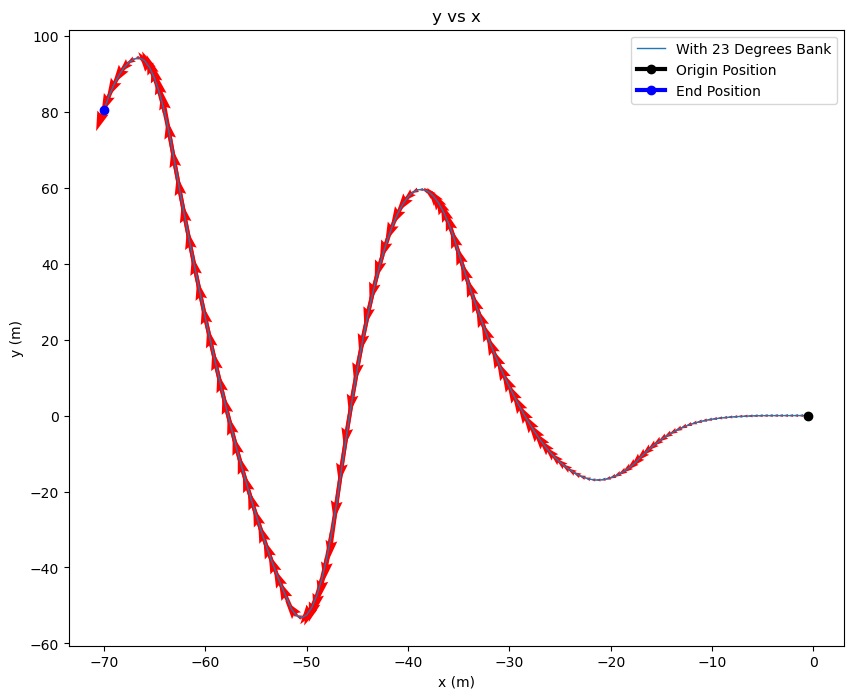

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(xd_array_bank, yd_array_bank, linewidth=1, label = "With 23 Degrees Bank")
plt.plot(xd_array_bank[0], yd_array_bank[0], c='black', marker='o', label = "Origin Position", linewidth=3) 
plt.plot(xd_array_bank[-1], yd_array_bank[-1], c='b', marker='o', label = "End Position", linewidth=3) 
plt.quiver(xd_array_bank[:-1], yd_array_bank[:-1], xd_array_bank[1:]-xd_array_bank[:-1], yd_array_bank[1:]-yd_array_bank[:-1], scale_units='x', angles='xy', scale=1, color = "r")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("y vs x")
plt.legend()
plt.show()